# **Specialty Coffee Case Study**




# Problem Overview
## Problem Statement
What percentage of RR Diner Coffee customers will purchase coffee from a legendary coffee farm in rural China?

## Context
RR Diner Coffee is experiencing drastically lower sales and popularity. Although a deal with **Hidden Farm** will not be cheap, if a significant portion of customers purchase it it will allow the business to remain open.

# Background Information
## Domain and Business Context
### RR Diner Coffee
- A coffee producer who sells:
    - specialty coffee beans, in bulk (by kg)
    - coffee equipment, including grinders and brewing equipment
    - merchandise, including mugs, books, and t-shirts
- Has three stores:
    - Two in Europe
    - One in the USA (flagship store)
        - Everything is quality assessed in the flagship store before being shipped out
        - Further away from the flagship, higher shipping charges
- Buys coffee from farmers, processes it on site, and brings it back to the USA for processing.

### Hidden Farm
- **Hidden Farm** is a legendary coffee farm in rural China who reached out to RR Diner to strike a deal
- Not clear whether or not customers will buy the coffee

## Data Origin and Characteristics
- A survey was conducted of 710 of the most loyal RR Diner Coffee customers.
- Dataset features:
    - Age
    - Gender
    - Salary
    - Purchased at least one RR Diner Coffee product online?
    - Distance from the flagship store (standardized to a number between 0 and 11)
    - How much spent on RR Diner Coffee products on the week of the survey.
    - How much spent on RR Diner Coffee products in the month preceding the survey.
    - Number of RR Diner Coffee bean shipments each customer ordered over the preceding year.
    - Would purchase Hidden Farm Coffee

# Data Wrangling
## Imports

In [190]:
import pandas as pd
import numpy as np

# Sci-kit learn
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO  
from IPython.display import Image  
import graphviz
import pydotplus

# String Matching
from thefuzz import process

## Load Data

In [137]:
# Load Data

path = './data/RRDinerCoffeeData.csv'

coffee_df = pd.read_csv(path)

In [138]:
# Inspect dataset

coffee_df.head()

,Age,Gender,num_coffeeBags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision
0,36,Female,0,24,73,42789,0.003168,0,1.0
1,24,Male,0,44,164,74035,0.520906,0,NaN
2,24,Male,0,39,119,30563,0.916005,1,1.0
3,20,Male,0,30,107,13166,0.932098,1,NaN
4,24,Female,0,20,36,14244,0.965881,0,1.0


In [139]:
# Investigate shape of data

coffee_df.shape

(702, 9)

In [140]:
# Dataset inf

coffee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      702 non-null    int64  
 1   Gender                   702 non-null    object 
 2   num_coffeeBags_per_year  702 non-null    int64  
 3   spent_week               702 non-null    int64  
 4   spent_month              702 non-null    int64  
 5   SlrAY                    702 non-null    int64  
 6   Distance                 702 non-null    float64
 7   Online                   702 non-null    int64  
 8   Decision                 474 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 49.5+ KB


In [141]:
# Summary statistics of df

coffee_df.describe()

,Age,num_coffeeBags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,474.000000
mean,34.243590,2.710826,32.853276,107.923077,43819.843305,4.559186,0.531339,0.639241
std,13.927945,1.593629,15.731878,55.348485,26192.626943,3.116275,0.499373,0.480728
min,16.000000,0.000000,0.000000,0.000000,1617.000000,0.003168,0.000000,0.000000
25%,23.000000,1.000000,24.250000,62.000000,22812.250000,1.877812,0.000000,0.000000
50%,28.000000,3.000000,36.000000,113.500000,41975.000000,4.196167,1.000000,1.000000
75%,46.000000,4.000000,43.000000,150.750000,60223.000000,6.712022,1.000000,1.000000
max,90.000000,5.000000,62.000000,210.000000,182058.000000,10.986203,1.000000,1.000000


## Clean Data

- Replace float 1.0 and 0.0 values in `Decision` column to `Yes` and `No`
- Drop rows with missing `Decision` values
- Clean up values of the `gender` column
- Rename columns to maximize meaning and clarity

### Rename Columns

First, let's change the name of `spent_week`, `spent_month`, and `SlrAY` to `spent_last_week` and `spent_last_month` and `salary` respectively.

In [142]:
# Check out the names of our data's columns 
coffee_df.columns

Index(['Age', 'Gender', 'num_coffeeBags_per_year', 'spent_week', 'spent_month',
       'SlrAY', 'Distance', 'Online', 'Decision'],
      dtype='object')

In [143]:
# Make the relevant name changes to spent_week and spent_per_week.
coffee_df.rename(columns={'spent_week':'spent_last_week', 'spent_month':'spent_last_month', 'SlrAY':'salary'}, inplace=True)

In [144]:
# Check out the column names
coffee_df.columns

Index(['Age', 'Gender', 'num_coffeeBags_per_year', 'spent_last_week',
       'spent_last_month', 'salary', 'Distance', 'Online', 'Decision'],
      dtype='object')

### Gender

In [145]:
# Investigate Gender column
coffee_df['Gender'].value_counts()

Gender
Male      355
Female    340
female      1
F           1
f           1
FEMALE      1
MALE        1
male        1
M           1
Name: count, dtype: int64

In [146]:
# See the gender column's unique values 
coffee_df['Gender'].unique()

array(['Female', 'Male', 'female', 'F', 'f ', 'FEMALE', 'MALE', 'male',
       'M'], dtype=object)

Unify values in `Gender` column to be either 'Male' or 'Female'.

In [147]:
genders = ['Male', 'Female']

def standardize_gender(gender):
    return process.extractOne(gender, genders)[0]

In [148]:
# Replace all alternate values for Female and Male entries with correct ones

coffee_df['Gender'] = coffee_df['Gender'].apply(standardize_gender)

In [149]:
# Verify results

coffee_df['Gender'].value_counts()

Gender
Male      358
Female    344
Name: count, dtype: int64

### Decision

Replace `1.0` and `0.0` in the `Decision` column by `YES` and `NO` respectively.

In [150]:
# Replace 1.0 and 0.0 by 'Yes' and 'No'

coffee_df['Decision'] = coffee_df['Decision'].map({1.0:'Yes', 0.0:'No'})

In [151]:
# Check that our replacing those values with 'YES' and 'NO' worked, with unique()

coffee_df['Decision'].unique()

array(['Yes', nan, 'No'], dtype=object)

Need to drop `null` values.

In [152]:
coffee_df['Decision'].isna().sum()

228

In [153]:
# Drop all rows that have a missing value for decision

decision_coffee_df = coffee_df.dropna(subset=['Decision'])

# Verify results

decision_coffee_df['Decision'].isna().sum()

0

# Model Preprocessing

In [154]:
# Investigate data with decision values

decision_coffee_df.describe()

,Age,num_coffeeBags_per_year,spent_last_week,spent_last_month,salary,Distance,Online
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,35.417722,2.590717,32.592827,106.727848,44731.892405,5.102898,0.512658
std,13.604135,1.585211,15.758109,56.101085,25567.674430,3.354891,0.500368
min,16.000000,0.000000,0.000000,0.000000,3150.000000,0.003168,0.000000
25%,25.000000,1.000000,24.000000,60.000000,27284.250000,2.077965,0.000000
50%,29.000000,3.000000,35.000000,113.500000,42791.500000,4.832168,1.000000
75%,49.000000,4.000000,43.000000,150.000000,61621.750000,7.869086,1.000000
max,90.000000,5.000000,62.000000,210.000000,172658.000000,10.986203,1.000000


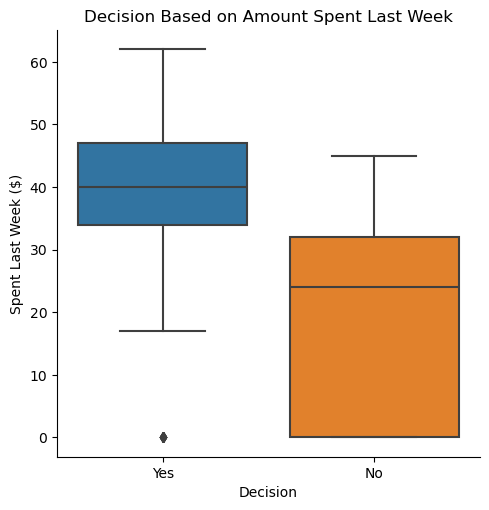

In [155]:
# Visualize decision_coffee_df

sns.catplot(x='Decision', y='spent_last_week', kind='box', data=decision_coffee_df)

plt.ylabel('Spent Last Week ($)')
plt.title('Decision Based on Amount Spent Last Week')

plt.show()

It looks like survey respondents who spent more money in the previous week are more likely to purchase the coffee. There is a single outlier in the group however, who has not spent anything last week but would still buy the new coffee.

The group who would not buy the new coffee appear to be significantly left skewed, which means that there are significantly more people in this group who spent somewhere between $20-30 dollars last week. There is also a concentration of people who didn't spend anything last week, shown by the lack of a lower whisker. 

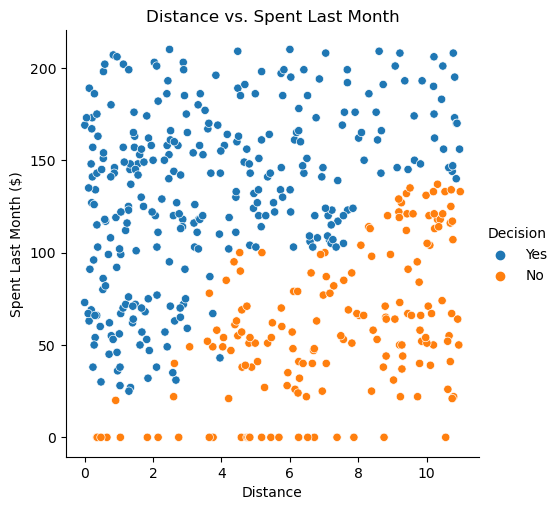

In [156]:
# Visualize distance vs. spent last month, grouped by decision

sns.relplot(x='Distance', y='spent_last_month', kind='scatter', hue='Decision', data=decision_coffee_df)

plt.ylabel('Spent Last Month ($)')
plt.title('Distance vs. Spent Last Month')

plt.show()

It looks like people who live closer to the flagship store in the US are more likely to have spent more last month. These individuals are also more likely to purchase Hidden Coffee. This also confirms our findings from the previous boxplot, which illustrated that people who spent more money last week were more willing to purchase Hidden Coffee. Here we can see a clear decision boundary between people willing to buy the new coffee vs. not.

### Separate data with no decision

In [157]:
# Get columns with no decision

prediction = coffee_df[coffee_df['Decision'].isna()]

In [158]:
# Get summary statistics of prediction

prediction.describe()

,Age,num_coffeeBags_per_year,spent_last_week,spent_last_month,salary,Distance,Online
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,31.802632,2.960526,33.394737,110.407895,41923.741228,3.428836,0.570175
std,14.302293,1.585514,15.697930,53.786536,27406.768360,2.153102,0.496140
min,16.000000,0.000000,0.000000,0.000000,1617.000000,0.010048,0.000000
25%,22.000000,2.000000,25.750000,65.000000,15911.500000,1.699408,0.000000
50%,25.000000,3.000000,37.000000,113.500000,40987.500000,3.208673,1.000000
75%,39.000000,4.000000,44.000000,151.250000,58537.000000,5.261184,1.000000
max,67.000000,5.000000,62.000000,210.000000,182058.000000,10.871566,1.000000


### Prepare X and y data

In [159]:
# Check the names of the columns of NOPrediction

decision_coffee_df.columns

Index(['Age', 'Gender', 'num_coffeeBags_per_year', 'spent_last_week',
       'spent_last_month', 'salary', 'Distance', 'Online', 'Decision'],
      dtype='object')

In [160]:
# Separate X and y data

X = decision_coffee_df.drop('Decision', axis=1)
y = decision_coffee_df['Decision']

### Convert categorical variables into dummies

In [161]:
# One-hot encode all features in X.

X = pd.get_dummies(X, drop_first=True)
X

,Age,num_coffeeBags_per_year,spent_last_week,spent_last_month,salary,Distance,Online,Gender_Male
0,36,0,24,73,42789,0.003168,0,False
2,24,0,39,119,30563,0.916005,1,True
4,24,0,20,36,14244,0.965881,0,False
5,20,0,23,28,14293,1.036346,1,False
6,34,0,55,202,91035,1.134851,0,False
...,...,...,...,...,...,...,...,...
696,29,5,20,74,29799,10.455068,0,False
697,45,5,61,201,80260,10.476341,0,False
698,54,5,44,116,44077,10.693889,1,True
699,63,5,33,117,43081,10.755194,1,True


### Train test split data

In [162]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=246)

# Modeling

## Model 1: Entropy model - no max_depth

In [163]:
# Initialize model using entropy

entr_model = DecisionTreeClassifier(criterion='entropy')

# Fit model to training data

entr_model.fit(X_train, y_train)

# Make predictions

y_pred = entr_model.predict(X_test)

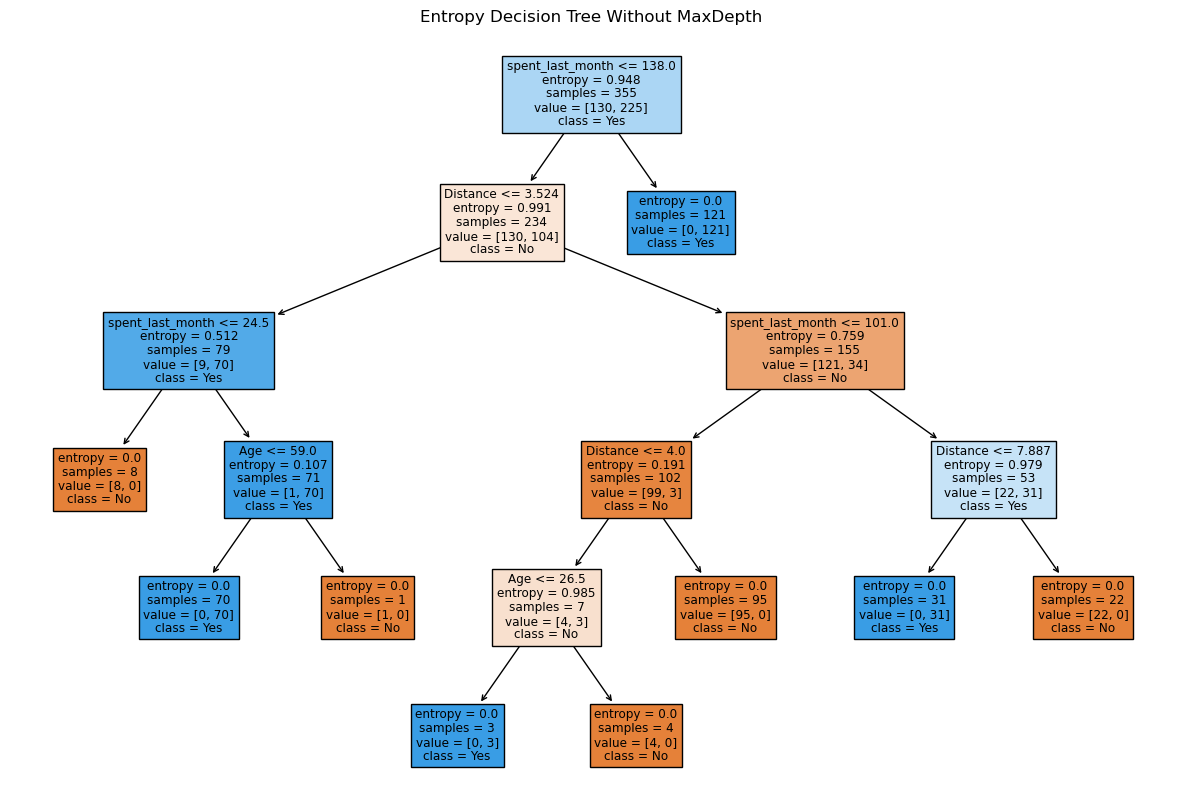

In [164]:
# Visualize the tree

plt.figure(figsize=(15,10))
tree.plot_tree(entr_model, feature_names=entr_model.feature_names_in_, class_names=entr_model.classes_, filled=True)
plt.title('Entropy Decision Tree Without MaxDepth')

plt.show()

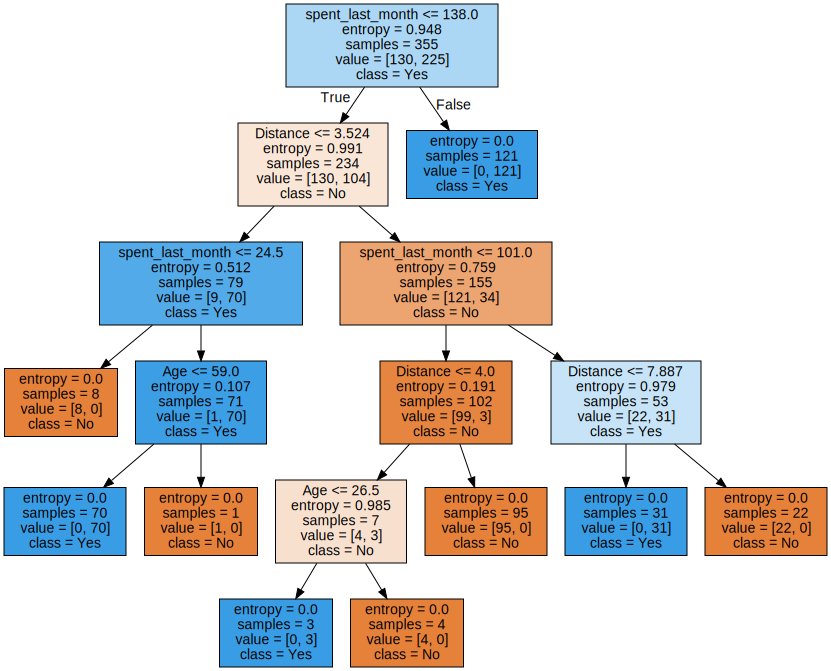

In [165]:
# Visualize using graphviz

dot_data = tree.export_graphviz(entr_model, out_file=None, feature_names=entr_model.feature_names_in_, class_names=entr_model.classes_, filled=True)

# Draw graph

graph = graphviz.Source(dot_data, format='png')
graph

### Interpretation and evaluation

In [166]:
# Model evaluation metrics

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       1.00      0.98      0.99        41
         Yes       0.99      1.00      0.99        78

    accuracy                           0.99       119
   macro avg       0.99      0.99      0.99       119
weighted avg       0.99      0.99      0.99       119



In [167]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n          No       1.00      0.98      0.99        41\n         Yes       0.99      1.00      0.99        78\n\n    accuracy                           0.99       119\n   macro avg       0.99      0.99      0.99       119\nweighted avg       0.99      0.99      0.99       119\n'

The model is always correct when predicting 'No'. It also correctly predicted individuals who would purchase Hidden Farm coffee. The model also has a high accuracy and high f1-score, which is a balance between precision and recall. 

## Model 2: Gini impurity model - no max_depth

In [168]:
# Decision tree using Gini inde

gini_model = DecisionTreeClassifier(criterion='gini')

# Fit model

gini_model.fit(X_train, y_train)

# Predict

y_pred = gini_model.predict(X_test)

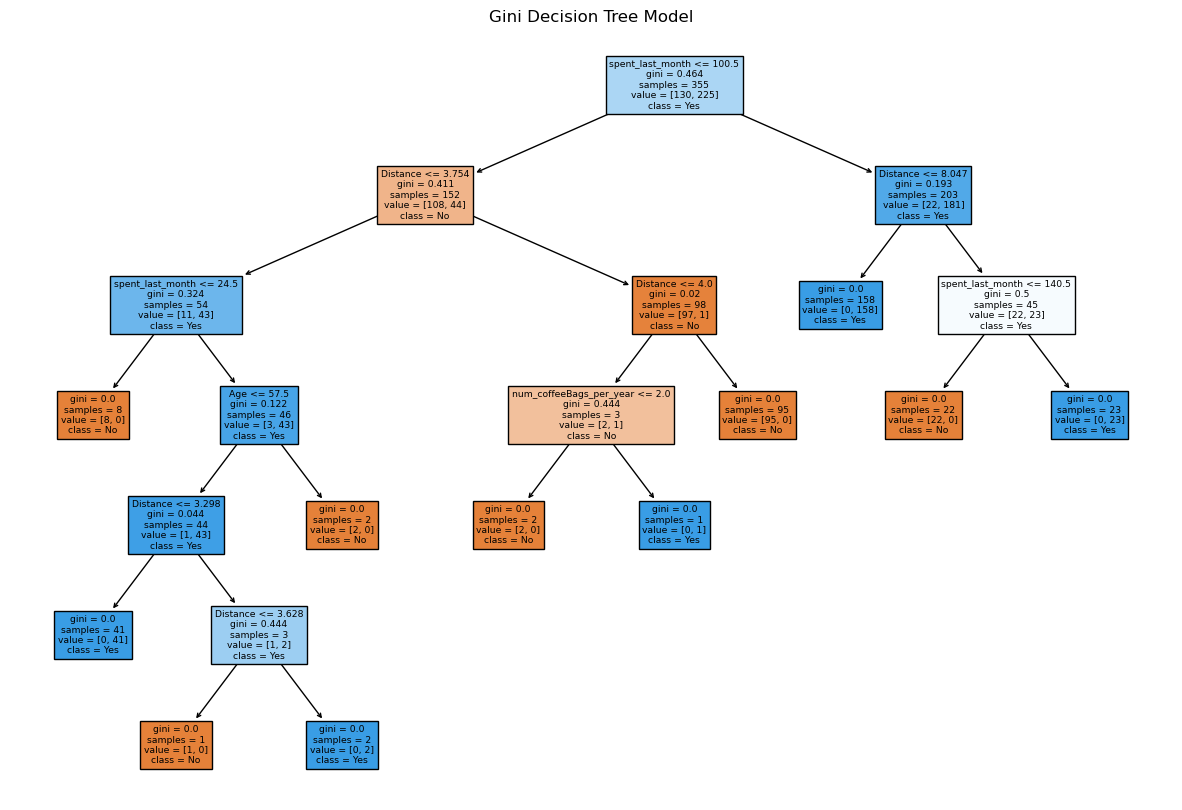

In [169]:
# Visualize preiction

plt.figure(figsize=(15, 10))
tree.plot_tree(gini_model, feature_names=gini_model.feature_names_in_, class_names=gini_model.classes_, filled=True)
plt.title('Gini Decision Tree Model')

plt.show()

### Interpretation and evaluation

In [170]:
# Run this block for model evaluation

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.97      0.95      0.96        41
         Yes       0.97      0.99      0.98        78

    accuracy                           0.97       119
   macro avg       0.97      0.97      0.97       119
weighted avg       0.97      0.97      0.97       119



This model was generally less accurate and precise than the model using entropy.

## Model 3: Entropy model - max depth 3

In [171]:
# Initialize model

entr_model = DecisionTreeClassifier(criterion='entropy', max_depth=3)

# Fit model

entr_model.fit(X_train, y_train)

# Predict

y_pred = entr_model.predict(X_test)

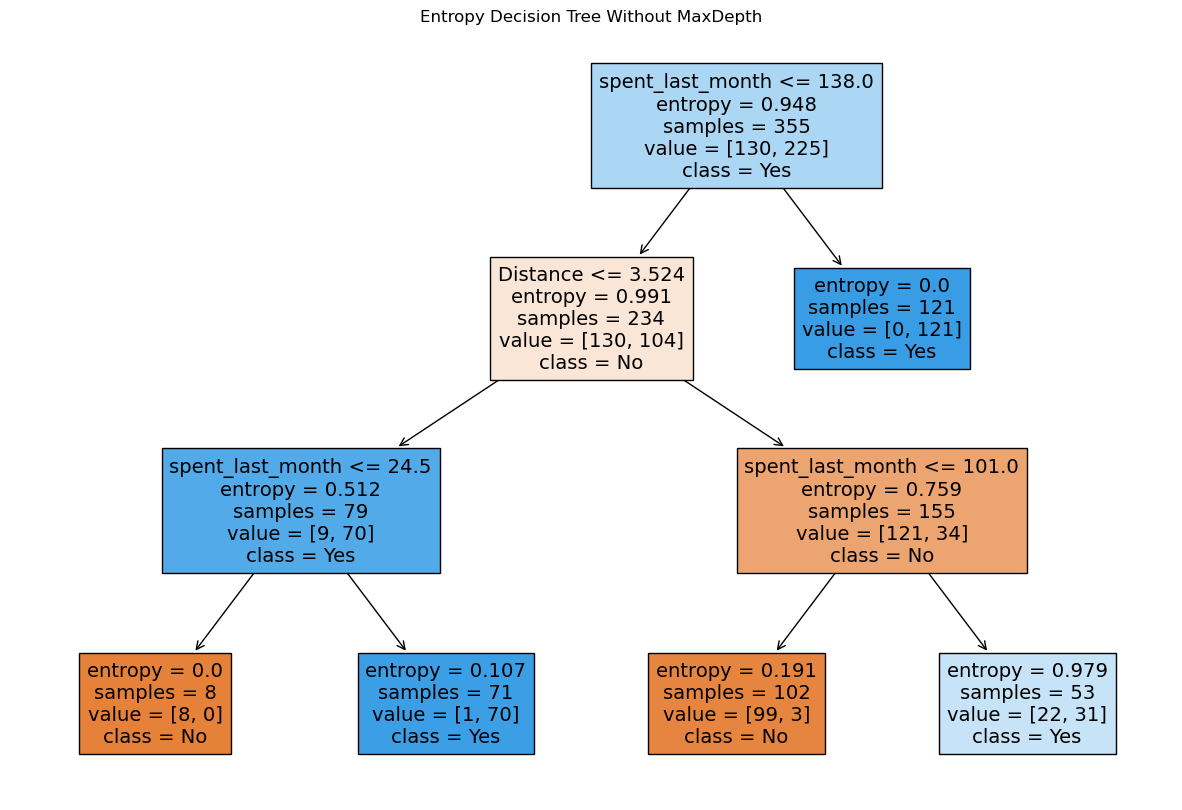

In [172]:
# Visualize tree

plt.figure(figsize=(15,10))
tree.plot_tree(entr_model, feature_names=entr_model.feature_names_in_, class_names=entr_model.classes_, filled=True)
plt.title('Entropy Decision Tree Without MaxDepth')

plt.show()

### Interpretation and evaluation

In [173]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       1.00      0.73      0.85        41
         Yes       0.88      1.00      0.93        78

    accuracy                           0.91       119
   macro avg       0.94      0.87      0.89       119
weighted avg       0.92      0.91      0.90       119



Although accuracy decreased along with the f1-score, this model was correct every time it predicted 'No,' and perfectly predicted all 'Yes' instances.

## Model 4: Gini impurity  model - max depth 3

In [174]:
# Initialize model

gini_model = DecisionTreeClassifier(max_depth=3)

# Fit model

gini_model.fit(X_train, y_train)

# Predict

y_pred = gini_model.predict(X_test)

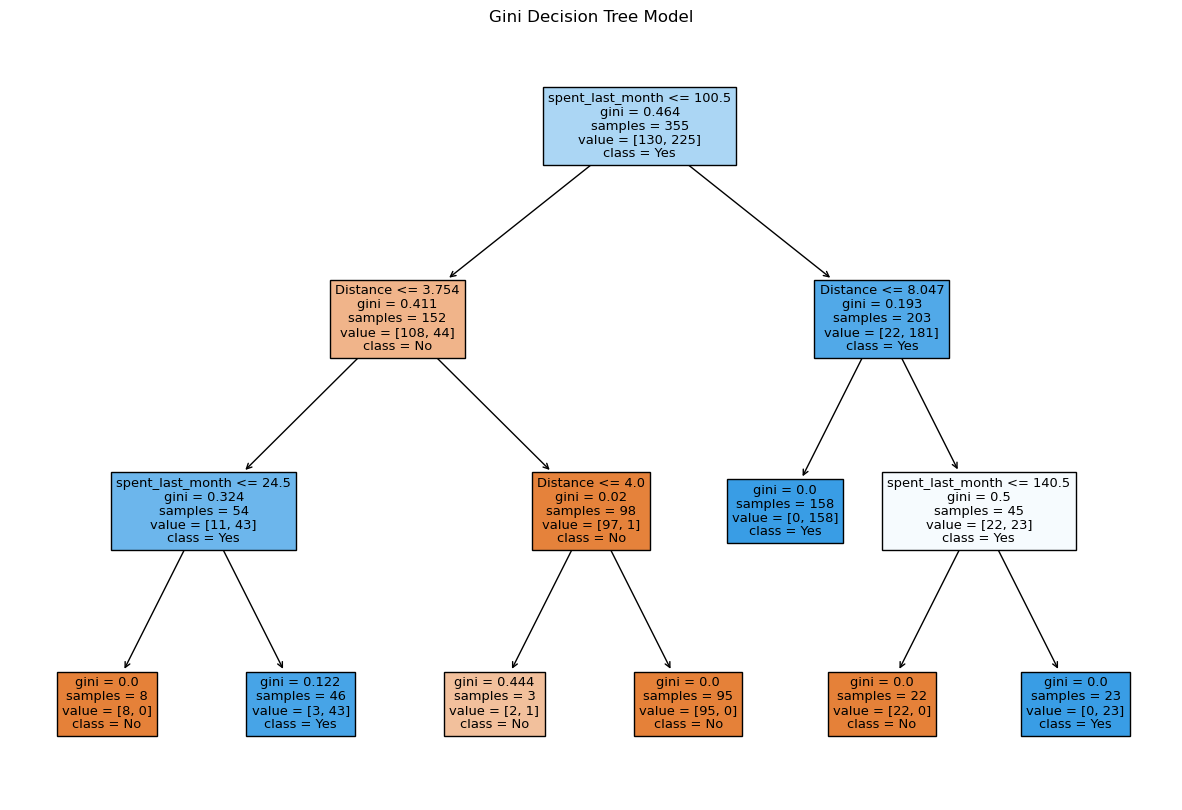

In [175]:
# Visualize preiction

plt.figure(figsize=(15, 10))
tree.plot_tree(gini_model, feature_names=gini_model.feature_names_in_, class_names=gini_model.classes_, filled=True)
plt.title('Gini Decision Tree Model')

plt.show()

### Interpretation and evaluation

In [176]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.97      0.95      0.96        41
         Yes       0.97      0.99      0.98        78

    accuracy                           0.97       119
   macro avg       0.97      0.97      0.97       119
weighted avg       0.97      0.97      0.97       119



Although some of the values are lower than te models with no specified max depth, they are still relatively high. In addition, including the `max_depth` parameter allowed us to create a more efficient model that is less likely to overfit the data.

## Model 5: Random Forest

In [191]:
# Initialize model

rf_model = RandomForestClassifier()

# Fit model

rf_model.fit(X_train, y_train)

# Make predictions

y_pred = rf_model.predict(X_test)

In [192]:
# Evaluate model

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.97      0.93      0.95        41
         Yes       0.96      0.99      0.97        78

    accuracy                           0.97       119
   macro avg       0.97      0.96      0.96       119
weighted avg       0.97      0.97      0.97       119



# Evaluating and concluding
## How many customers will buy Hidden Farm coffee? 

How many people, according to the survey, will buy Hidden Farm coffee?

In [177]:
# Count values

decision_coffee_df['Decision'].value_counts()

Decision
Yes    303
No     171
Name: count, dtype: int64

Predict number of potential buyers from list of surveyers with `NaN` value for `Decision`

In [178]:
# Create list of features

feature_cols = decision_coffee_df.drop('Decision', axis=1).columns

# Store rows with no value for decision in new_X

new_X = prediction[feature_cols]

In [196]:
# One-hot encode new_X

new_X = pd.get_dummies(new_X, drop_first=True)

# Make prediction using gini model

potential_buyers = gini_model.predict(new_X)

# Make prediction using random forest model

potential_buyers_rf = rf_model.predict(new_X)

In [197]:
# Count responses

unique_values, counts = np.unique(potential_buyers, return_counts=True)
print("Gini Model Predictions")
print(f"\t{unique_values[0]}: {counts[0]}")
print(f"\t{unique_values[1]}: {counts[1]}")

unique_values, counts = np.unique(potential_buyers_rf, return_counts=True)

print("Random Forest Model Predictions")
print(f"\t{unique_values[0]}: {counts[0]}")
print(f"\t{unique_values[1]}: {counts[1]}")

Gini Model Predictions
	No: 45
	Yes: 183
Random Forest Model Predictions
	No: 43
	Yes: 185


In [183]:
# Total number of surveyed people

total_respondents = len(coffee_df)

print(total_respondents)

702


In [198]:
# Calculate predicted number of buyers

total_buyers = len(decision_coffee_df[decision_coffee_df['Decision'] == 'Yes'])

print("Gini Model Buyers")
print(f"\tBuyers: {round((total_buyers +183) / total_respondents * 100)}%")

print("Random Forest Buyers")
print(f"\tBuyers: {round((total_buyers +185) / total_respondents * 100)}%")

Gini Model Buyers
	Buyers: 69%
Random Forest Buyers
	Buyers: 70%


## Decision

Although solely based on our Gini Model we would not take the risk to strike the deal with Hidden Coffee, our Random Forest model meets our threshold of 70%. Since Random Forests are more reliable, we will trust this prediction and make the deal.